# 🦀[Telegram-Leecher](https://github.com/XronTrix10/Telegram-Leecher)🦀

1. ⬆️ Upload Your Custom THUMBNAIL ( name = thmb.jpg )

2. ⬆️ Upload Your token.pickle File

### ⚠️ NOTE: File names should be exactly same as mentioned

## 👇 It should look like 👇
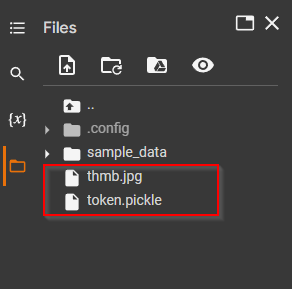

In [ ]:
#@title ⚙️ Set-up Modules and Environments [ MUST ]

!git clone https://github.com/nekaru-storage/Telegram-Leecher -b backports &>/dev/null && bash /content/Telegram-Leecher/setup.sh &>/dev/null

import shutil, os
if os.path.exists("/content/sample_data"):
    shutil.rmtree("/content/sample_data")

print('Files and modules setup Successfull')

In [ ]:
#@title ✒️ Edit the Variables with your data and Run this cell
API_ID    = ""           # <== YOUR TELEGRAM API ID HERE
API_HASH  = ""           # <== YOUR TELEGRAM API HASH HERE ( Place Inside Quotes )
BOT_TOKEN = ""           # <== YOUR TELEGRAM BOT TOKEN HERE ( Place Inside Quotes )
CHAT_ID   = ""           # <== YOUR CHAT ID WHERE ALL STATUS AND LOGS WILL BE SHOWN
DUMP_ID   = ""           # <== CHAT ID WHERE ALL FILES WILL BE UPLOADED ( MUST BE A CHANNEL OR SUPERGROUP ) [ ID STARTS WITH -100 ]
LEECH_DOCUMENT = False   # Change it to True to leech as Document

# ⚠️ 👇🏻 Edit The Below Variables Only If you are on Mobile 📱

'''
'L' => Leech
'Z' => ZipLeech
'U' => UnzipLeech

'''
LEECH_MODE  = ""           # <== Leech Mode
D_LINK      = ""           # <== YOUR Download Link
C_NAME      = ""           # <== Custom Name [ Leave Empty For Default ]

# NOTE: Currently only one link is supported for Mobile users

print('BOT Variables Initialized ! 💖')

# 🏃 RUN THE BELOW CELL TO START LEECHING 🦀

#### 📣 Join our Channel For Latest Updates and Features: [Colab Leecher](https://t.me/Colab_Leecher)

#### 💬 For any issues or suggestions, Ask in : [Discussion Group](https://t.me/+2n9HLR2F1uJhZGY1)

In [ ]:
# @title 🖥️ Main Colab Leech Code [ Click on RUN for Magic ✨ ]
import os, io, re, sys, time, math, pytz, psutil, shutil, pickle, uvloop, pathlib, datetime, subprocess, asyncio
from PIL import Image
from pyrogram import Client
from natsort import natsorted
from urllib.parse import urlparse
from re import search as re_search
from os import makedirs, path as ospath
from mutagen import File
from IPython.display import clear_output
from urllib.parse import parse_qs, urlparse
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from moviepy.video.io.VideoFileClip import VideoFileClip
from pyrogram.types import (
    ReplyKeyboardMarkup,
    InlineKeyboardMarkup,
    InlineKeyboardButton,
)

uvloop.install()


# =================================================================
#    Local OS Functions
# =================================================================


def convert_seconds(seconds):
    seconds = int(seconds)
    days = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    if days > 0:
        return f"{days}d {hours}h {minutes}m {seconds}s"
    elif hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"


def size_measure(size):
    if size > 1024 * 1024 * 1024 * 1024 * 1024:
        siz = f"{size/(1024**5):.2f} PiB"
    elif size > 1024 * 1024 * 1024 * 1024:
        siz = f"{size/(1024**4):.2f} TiB"
    elif size > 1024 * 1024 * 1024:
        siz = f"{size/(1024**3):.2f} GiB"
    elif size > 1024 * 1024:
        siz = f"{size/(1024**2):.2f} MiB"
    elif size > 1024:
        siz = f"{size/1024:.2f} KiB"
    else:
        siz = f"{size} B"
    return siz


def get_file_type(file_path):
    extensions_dict = {
        ".mp4": "video",
        ".avi": "video",
        ".mkv": "video",
        ".mov": "video",
        ".webm": "video",
        ".vob": "video",
        ".m4v": "video",
        ".mp3": "audio",
        ".wav": "audio",
        ".flac": "audio",
        ".aac": "audio",
        ".ogg": "audio",
        ".jpg": "photo",
        ".jpeg": "photo",
        ".png": "photo",
        ".gif": "photo",
    }
    _, extension = os.path.splitext(file_path)

    if extension.lower() in extensions_dict:
        if extensions_dict[extension] == "video":
            new_path = video_extension_fixer(file_path)
        else:
            new_path = file_path
        return extensions_dict[extension], new_path
    else:
        return "document", file_path


def shorterFileName(path):
    if os.path.isfile(path):
        dir_path, filename = os.path.split(path)
        if len(filename) > 60:
            basename, ext = os.path.splitext(filename)
            basename = basename[: 60 - len(ext)]
            filename = basename + ext
            path = os.path.join(dir_path, filename)
        return path
    elif os.path.isdir(path):
        dir_path, dirname = os.path.split(path)
        if len(dirname) > 60:
            dirname = dirname[:60]
            path = os.path.join(dir_path, dirname)
        return path
    else:
        if len(path) > 60:
            path = path[:60]
        return path


def get_folder_size(folder_path):
    if os.path.isfile(folder_path):
        return os.path.getsize(folder_path)
    else:
        total_size = 0
        for dirpath, _, filenames in os.walk(folder_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        return total_size


def get_file_count(folder_path):
    count = 0
    for _, __, filenames in os.walk(folder_path):
        for f_ in filenames:
            count += 1
    return count


def video_extension_fixer(file_path):
    _, f_name = os.path.split(file_path)
    if f_name.endswith(".mp4") or f_name.endswith(".mkv"):
        return file_path
    else:
        os.rename(file_path, os.path.join(file_path + ".mp4"))
        return os.path.join(file_path + ".mp4")


def Thumbnail_Maintainer(file_path):
    thmb = f"{d_path}/video_frame.jpg"
    if os.path.exists(thmb):
        os.remove(thmb)
    try:
        with VideoFileClip(file_path) as video:
            if os.path.exists(custom_thumb):
                return custom_thumb, video.duration
            else:
                video.save_frame(thmb, t=math.floor(video.duration / 2))
                return thmb, video.duration
    except Exception as e:
        print(f"Thmb Gen ERROR: {e}")
        return thumb_path, 0


def Thumbnail_Checker(dir_path):
    for filename in os.listdir(dir_path):
        if filename.endswith(".jpg"):
            os.rename(os.path.join(dir_path, filename), custom_thumb)
            return True
    # No jpg file was found
    return False


def system_info():
    ram_usage = psutil.Process(os.getpid()).memory_info().rss
    disk_usage = psutil.disk_usage("/")
    cpu_usage_percent = psutil.cpu_percent()

    string = "\n\n⍟───── [Colab Usage](https://colab.research.google.com/drive/12hdEqaidRZ8krqj7rpnyDzg1dkKmvdvp) ─────⍟\n"
    string += f"\n╭🖥️ **CPU Usage »**  __{cpu_usage_percent}%__"
    string += f"\n├💽 **RAM Usage »**  __{size_measure(ram_usage)}__"
    string += f"\n╰💾 **DISK Free »**  __{size_measure(disk_usage.free)}__"
    string += f"\n\n<i>💖 When I'm Doin This, Do Something Else ! **Because, Time Is Precious ✨**</i>"

    return string


async def zip_folder(path):
    dir_p, p_name = os.path.split(path)
    r = "-r" if os.path.isdir(path) else ""
    if len(custom_name) != 0:
        name = custom_name
    elif os.path.isfile(path):
        name = os.path.basename(path)
    else:
        name = d_name
    zip_msg = f"<b>🔐 ZIPPING » </b>\n\n<code>{name}</code>\n"
    starting_time = datetime.datetime.now()
    cmd = f'cd "{dir_p}" && zip {r} -s 2000m -0 "{temp_zpath}/{name}.zip" "{p_name}"'
    proc = subprocess.Popen(cmd, shell=True)
    total = size_measure(get_folder_size(path))
    while proc.poll() is None:
        speed_string, eta, percentage = speed_eta(
            starting_time, get_folder_size(temp_zpath), get_folder_size(path)
        )
        await status_bar(
            zip_msg,
            speed_string,
            percentage,
            convert_seconds(eta),
            size_measure(get_folder_size(temp_zpath)),
            total,
            "Xr-Zipp 🔒",
        )
        time.sleep(1)
    if os.path.isfile(path):
        os.remove(path)
    else:
        shutil.rmtree(path)


async def extract_zip(zip_filepath):
    starting_time = datetime.datetime.now()
    dirname, filename = os.path.split(zip_filepath)
    unzip_msg = f"<b>📂 EXTRACTING »</b>\n\n<code>{filename}</code>\n"
    file_pattern = ""
    name, ext = os.path.splitext(filename)
    if ext == ".rar":
        if "part" in name:
            cmd = f"unrar x -kb -idq '{zip_filepath}' {temp_unzip_path}"
            file_pattern = "rar"
        else:
            cmd = f"unrar x '{zip_filepath}' {temp_unzip_path}"

    elif ext == ".tar":
        cmd = f"tar -xvf '{zip_filepath}' -C {temp_unzip_path}"
    elif ext == ".gz":
        cmd = f"tar -zxvf '{zip_filepath}' -C {temp_unzip_path}"
    else:
        cmd = f"7z x '{zip_filepath}' -o{temp_unzip_path}"
        if ext == ".001":
            file_pattern = "7z"
        elif ext == ".z01":
            file_pattern = "zip"

    proc = subprocess.Popen(cmd, shell=True)
    total = size_measure(get_folder_size(zip_filepath))
    while proc.poll() is None:
        speed_string, eta, percentage = speed_eta(
            starting_time,
            get_folder_size(temp_unzip_path),
            get_folder_size(zip_filepath),
        )
        await status_bar(
            unzip_msg,
            speed_string,
            percentage,
            convert_seconds(eta),
            size_measure(get_folder_size(temp_unzip_path)),
            total,
            "Xr-Unzip 🔓",
        )
        time.sleep(1)

    # Deletes all remaining Multi Part Volumes
    c = 1
    if file_pattern == "rar":
        name_, _ = os.path.splitext(name)
        na_p = name_ + ".part" + str(c) + ".rar"
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name_ + ".part" + str(c) + ".rar"
            p_ap = os.path.join(dirname, na_p)

    elif file_pattern == "7z":
        na_p = name + "." + str(c).zfill(3)
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name + "." + str(c).zfill(3)
            p_ap = os.path.join(dirname, na_p)

    elif file_pattern == "zip":
        na_p = name + ".zip"
        p_ap = os.path.join(dirname, na_p)
        if os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
        na_p = name + ".z" + str(c).zfill(2)
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("Deleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name + ".z" + str(c).zfill(2)
            p_ap = os.path.join(dirname, na_p)

    if os.path.exists(zip_filepath):
        os.remove(zip_filepath)


async def size_checker(file_path):
    max_size = 2097152000  # 2 GB
    file_size = os.stat(file_path).st_size

    if file_size > max_size:
        if not ospath.exists(temp_lpath):
            makedirs(temp_lpath)
        _, filename = os.path.split(file_path)
        filename = filename.lower()
        if (
            filename.endswith(".zip")
            or filename.endswith(".rar")
            or filename.endswith(".7z")
            or filename.endswith(".tar")
            or filename.endswith(".gz")
        ):
            await split_zipFile(file_path, max_size)
        else:
            await zip_folder(file_path)
            time.sleep(2)
        return True
    else:
        return False


async def split_zipFile(file_path, max_size):
    starting_time = datetime.datetime.now()
    _, filename = os.path.split(file_path)
    new_path = f"{temp_lpath}/{filename}"
    down_msg = f"<b>✂️ SPLITTING » </b>\n\n<code>{filename}</code>\n"
    # Get the total size of the file
    total_size = os.path.getsize(file_path)
    with open(file_path, "rb") as f:
        chunk = f.read(max_size)
        i = 1
        bytes_written = 0
        while chunk:
            # Generate filename for this chunk
            ext = str(i).zfill(3)
            output_filename = "{}.{}".format(new_path, ext)

            # Write chunk to file
            with open(output_filename, "wb") as out:
                out.write(chunk)

            bytes_written += len(chunk)
            speed_string, eta, percentage = speed_eta(
                starting_time, bytes_written, total_size
            )
            await status_bar(
                down_msg,
                speed_string,
                percentage,
                convert_seconds(eta),
                size_measure(bytes_written),
                size_measure(total_size),
                "Xr-Split ✂️",
            )
            # Get next chunk
            chunk = f.read(max_size)
            i += 1  # Increment chunk counter


def is_time_over(current_time):
    ten_sec_passed = time.time() - current_time[0] >= 3
    if ten_sec_passed:
        current_time[0] = time.time()
    return ten_sec_passed


def speed_eta(start, done, total):
    percentage = (done / total) * 100
    elapsed_time = (datetime.datetime.now() - start).seconds
    if done > 0 and elapsed_time != 0:
        raw_speed = done / elapsed_time
        speed = f"{size_measure(raw_speed)}/s"
        eta = (total - done) / raw_speed
    else:
        speed, eta = "N/A", 0
    return speed, eta, percentage


# =================================================================
#    Direct Link Handler Functions
# =================================================================


async def on_output(output: str):
    # print("=" * 60 + f"\n\n{output}\n\n" + "*" * 60)
    global link_info
    total_size = "0B"
    progress_percentage = "0B"
    downloaded_bytes = "0B"
    eta = "0S"
    try:
        if "ETA:" in output:
            parts = output.split()
            total_size = parts[1].split("/")[1]
            total_size = total_size.split("(")[0]
            progress_percentage = parts[1][parts[1].find("(") + 1 : parts[1].find(")")]
            downloaded_bytes = parts[1].split("/")[0]
            eta = parts[4].split(":")[1][:-1]
    except Exception as do:
        print(f"Could't Get Info Due to: {do}")

    percentage = re.findall("\d+\.\d+|\d+", progress_percentage)[0]
    down = re.findall("\d+\.\d+|\d+", downloaded_bytes)[0]
    down_unit = re.findall("[a-zA-Z]+", downloaded_bytes)[0]
    if "G" in down_unit:
        spd = 3
    elif "M" in down_unit:
        spd = 2
    elif "K" in down_unit:
        spd = 1
    else:
        spd = 0

    elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds

    if elapsed_time_seconds >= 270 and not link_info:
        raise Exception("Failed to get download information ! Probably dead link 💀")
    # Only Do this if got Information
    if total_size != "0B":
        # Calculate download speed
        link_info = True
        current_speed = (float(down) * 1024**spd) / elapsed_time_seconds
        speed_string = f"{size_measure(current_speed)}/s"

        await status_bar(
            down_msg,
            speed_string,
            int(percentage),
            eta,
            downloaded_bytes,
            total_size,
            "Aria2c 🧨",
        )


async def aria2_Download(link, num):
    global start_time, down_msg
    name_d = get_Aria2c_Name(link)
    start_time = datetime.datetime.now()
    down_msg = f"<b>📥 DOWNLOADING FROM » </b><i>🔗Link {str(num).zfill(2)}</i>\n\n<b>🏷️ Name » </b><code>{name_d}</code>\n"

    # Create a command to run aria2p with the link
    command = [
        "aria2c",
        "-x16",
        "--seed-time=0",
        "--summary-interval=1",
        "--console-log-level=notice",
        "-d",
        d_fol_path,
        link,
    ]

    # Run the command using subprocess.Popen
    proc = subprocess.Popen(
        command, bufsize=0, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )

    # Read and print output in real-time
    while True:
        output = proc.stdout.readline()
        if output == b"" and proc.poll() is not None:
            break
        if output:
            # sys.stdout.write(output.decode("utf-8"))
            # sys.stdout.flush()
            await on_output(output.decode("utf-8"))

    # Retrieve exit code and any error output
    exit_code = proc.wait()
    error_output = proc.stderr.read()
    if exit_code != 0:
        raise Exception(
            f"aria2c download failed with return code {exit_code}. Error: {error_output}"
        )


# =================================================================
#    Telegram Downloader
# =================================================================


async def media_Identifier(link):
    parts = link.split("/")
    message_id = parts[-1]
    msg_chat_id = "-100" + parts[4]
    message_id, msg_chat_id = int(message_id), int(msg_chat_id)
    message = await bot.get_messages(msg_chat_id, message_id)

    media = (
        message.document
        or message.photo
        or message.video
        or message.audio
        or message.voice
        or message.video_note
        or message.sticker
        or message.animation
        or None
    )
    if media is None:
        raise Exception("Couldn't Download Telegram Message")
    return media, message


async def download_progress(current, total):
    speed_string, eta, percentage = speed_eta(start_time, current, total)

    await status_bar(
        down_msg=down_msg,
        speed=speed_string,
        percentage=percentage,
        eta=convert_seconds(eta),
        done=size_measure(sum(down_bytes) + current),
        left=size_measure(folder_info[0]),
        engine="Pyrogram 💥",
    )


async def TelegramDownload(link, num):
    global start_time, down_msg
    media, message = await media_Identifier(link)
    if media is not None:
        name = media.file_name if hasattr(media, "file_name") else "None"
    else:
        raise Exception("Couldn't Download Telegram Message")

    down_msg = f"<b>📥 DOWNLOADING FROM » </b><i>🔗Link {str(num).zfill(2)}</i>\n\n<code>{name}</code>\n"
    start_time = datetime.datetime.now()
    file_path = os.path.join(d_fol_path, name)
    await message.download(
        progress=download_progress, in_memory=False, file_name=file_path
    )
    down_bytes.append(media.file_size)


# =================================================================
#    Initiator Functions
# =================================================================


async def calG_DownSize(links):
    for link in natsorted(links):
        if "drive.google.com" in link:
            id = getIDFromURL(link)
            try:
                meta = getFileMetadata(id)
            except Exception as e:
                if "File not found" in str(e):
                    raise Exception(
                        "The file link you gave either doesn't exist or You don't have access to it!"
                    )
                elif "Failed to retrieve" in str(e):
                    clear_output()
                    raise Exception(
                        "Authorization Error with Google ! Make Sure you uploaded token.pickle !"
                    )
                else:
                    raise Exception(f"Error in G-API: {e}")
            if meta.get("mimeType") == "application/vnd.google-apps.folder":
                folder_info[0] += get_Gfolder_size(id)
            else:
                folder_info[0] += int(meta["size"])
        elif "t.me" in link:
            media, _ = await media_Identifier(link)
            if media is not None:
                size = media.file_size
                folder_info[0] += size
            else:
                raise Exception("Couldn't Download Telegram Message")
        else:
            pass


def get_Aria2c_Name(link):
    cmd = f'aria2c -x10 --dry-run --file-allocation=none "{link}"'
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    stdout_str = result.stdout.decode("utf-8")
    filename = stdout_str.split("complete: ")[-1].split("\n")[0]
    name = filename.split("/")[-1]
    if len(name) == 0:
        name = "UNKNOWN DOWNLOAD NAME"
    return name


async def get_d_name(link):
    global d_name
    if custom_name:
        d_name = custom_name
        return
    if "drive.google.com" in link:
        id = getIDFromURL(link)
        meta = getFileMetadata(id)
        d_name = meta["name"]
    elif "t.me" in link:
        media, _ = await media_Identifier(link)
        d_name = media.file_name if hasattr(media, "file_name") else "None"
    else:
        d_name = get_Aria2c_Name(link)


# =================================================================
#    G Drive Functions
# =================================================================


def build_service():
    # create credentials object from token.pickle file
    creds = None
    if os.path.exists("/content/token.pickle"):
        with open("/content/token.pickle", "rb") as token:
            creds = pickle.load(token)
    else:
        exit(1)

    # create drive API client
    service = build("drive", "v3", credentials=creds)

    return service


async def g_DownLoad(link, num):
    global start_time, down_msg
    down_msg = f"<b>📥 DOWNLOADING FROM » </b><i>🔗Link {str(num).zfill(2)}</i>\n\n<b>🏷️ Name » </b><code>{d_name}</code>\n"
    file_id = getIDFromURL(link)
    meta = getFileMetadata(file_id)

    if meta.get("mimeType") == "application/vnd.google-apps.folder":
        await gDownloadFolder(file_id, d_fol_path)
    else:
        await gDownloadFile(file_id, d_fol_path)
        clear_output()


def getIDFromURL(link: str):
    if "folders" in link or "file" in link:
        regex = r"https:\/\/drive\.google\.com\/(?:drive(.*?)\/folders\/|file(.*?)?\/d\/)([-\w]+)"
        res = re_search(regex, link)
        if res is None:
            raise IndexError("G-Drive ID not found.")
        return res.group(3)
    parsed = urlparse(link)
    return parse_qs(parsed.query)["id"][0]


def getFilesByFolderID(folder_id):
    page_token = None
    files = []
    while True:
        response = (
            service.files()
            .list(
                supportsAllDrives=True,
                includeItemsFromAllDrives=True,
                q=f"'{folder_id}' in parents and trashed = false",
                spaces="drive",
                pageSize=200,
                fields="nextPageToken, files(id, name, mimeType, size, shortcutDetails)",
                orderBy="folder, name",
                pageToken=page_token,
            )
            .execute()
        )
        files.extend(response.get("files", []))
        page_token = response.get("nextPageToken")
        if page_token is None:
            break
    return files


def getFileMetadata(file_id):
    return (
        service.files()
        .get(fileId=file_id, supportsAllDrives=True, fields="name, id, mimeType, size")
        .execute()
    )


def get_Gfolder_size(folder_id):
    try:
        query = "trashed = false and '{0}' in parents".format(folder_id)
        results = (
            service.files()
            .list(
                supportsAllDrives=True,
                includeItemsFromAllDrives=True,
                q=query,
                fields="files(id, mimeType, size)",
            )
            .execute()
        )

        total_size = 0
        items = results.get("files", [])

        folders_without_size = (
            item["id"]
            for item in items
            if item.get("size") is None
            and item["mimeType"] == "application/vnd.google-apps.folder"
        )

        for item in items:
            # If the item has a size attribute
            if "size" in item:
                total_size += int(item["size"])

        # Recursively call the function for folders whose size is not found
        for folder_id in folders_without_size:
            total_size += get_Gfolder_size(folder_id)

        return total_size

    except HttpError as error:
        print(f"Error while checking size: {error}")
        return -1


async def gDownloadFile(file_id, path):
    # Check if the specified file or folder exists and is downloadable.
    try:
        file = getFileMetadata(file_id)
    except HttpError as error:
        print("An error occurred: {0}".format(error))
        file = None
    if file is None:
        print(
            "Sorry, the specified file or folder does not exist or is not accessible."
        )
    else:
        if file["mimeType"].startswith("application/vnd.google-apps"):
            print(
                "Sorry, the specified ID is for a Google Docs, Sheets, Slides, or Forms document. You can only download these types of files in specific formats."
            )
        else:
            try:
                file_name = file.get("name", f"untitleddrivefile_{file_id}")
                file_name = os.path.join(path, file_name)
                # Create a BytesIO stream to hold the downloaded file data.
                file_contents = io.BytesIO()

                # Download the file or folder contents to the BytesIO stream.
                request = service.files().get_media(
                    fileId=file_id, supportsAllDrives=True
                )
                file_downloader = MediaIoBaseDownload(
                    file_contents, request, chunksize=70 * 1024 * 1024
                )
                done = False
                while done is False:
                    status, done = file_downloader.next_chunk()
                    # Get current value from file_contents.
                    file_contents.seek(0)
                    with open(file_name, "ab") as f:
                        f.write(file_contents.getvalue())
                    # Reset the buffer for the next chunk.
                    file_contents.seek(0)
                    file_contents.truncate()
                    # The saved bytes till now
                    file_d_size = int(status.progress() * int(file["size"]))
                    down_done = sum(down_bytes) + file_d_size
                    speed_string, eta, percentage = speed_eta(
                        start_time, down_done, folder_info[0]
                    )
                    await status_bar(
                        down_msg=down_msg,
                        speed=speed_string,
                        percentage=percentage,
                        eta=convert_seconds(eta),
                        done=size_measure(down_done),
                        left=size_measure(folder_info[0]),
                        engine="G-API ♻️",
                    )
                down_bytes.append(int(file["size"]))
                down_count[0] += 1

            except Exception as e:
                print("Error downloading: {0}".format(e))


async def gDownloadFolder(folder_id, path):
    folder_meta = getFileMetadata(folder_id)
    folder_name = folder_meta["name"]
    if not ospath.exists(f"{path}/{folder_name}"):
        makedirs(f"{path}/{folder_name}")
    path += f"/{folder_name}"
    result = getFilesByFolderID(folder_id)
    if len(result) == 0:
        return
    result = natsorted(result, key=lambda k: k["name"])
    for item in result:
        file_id = item["id"]
        shortcut_details = item.get("shortcutDetails")
        if shortcut_details is not None:
            file_id = shortcut_details["targetId"]
            mime_type = shortcut_details["targetMimeType"]
        else:
            mime_type = item.get("mimeType")
        if mime_type == "application/vnd.google-apps.folder":
            await gDownloadFolder(file_id, path)
        else:
            await gDownloadFile(file_id, path)


# =================================================================
#    Telegram Upload Functions
# =================================================================


def keyboard():
    return InlineKeyboardMarkup(
        [
            [  # First row
                InlineKeyboardButton(  # Opens a web URL
                    "Git Repo 🪲",
                    url="https://github.com/XronTrix10/Telegram-Leecher",
                ),
            ],
        ]
    )


async def status_bar(down_msg, speed, percentage, eta, done, left, engine):
    bar_length = 12
    filled_length = int(percentage / 100 * bar_length)
    # bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
    bar = "█" * filled_length + "░" * (bar_length - filled_length)
    message = (
        f"\n╭|{bar}| » __{percentage:.2f}%__\n├⚡️ **Speed »** __{speed}__\n├⚙️ **Engine »** __{engine}__"
        + f"\n├⏳ **Time Left »** __{eta}__"
        + f"\n├🍃 **Time Spent »** __{convert_seconds((datetime.datetime.now() - task_start).seconds)}__"
        + f"\n├✅ **Processed »** __{done}__\n╰📦 **Total Size »** __{left}__"
    )
    sys_text = system_info()
    try:
        print(f"\r{engine} ║ {bar} ║ {percentage:.2f}% ║ {speed} ║ ⏳ {eta}", end="")
        # Edit the message with updated progress information.
        if is_time_over(current_time):
            await bot.edit_message_text(
                chat_id=chat_id,
                message_id=msg.id,
                text=task_msg + down_msg + message + sys_text,
                reply_markup=keyboard(),
            )

    except Exception as e:
        # Catch any exceptions that might occur while editing the message.
        print(f"Error Updating Status bar: {str(e)}")


async def progress_bar(current, total):
    upload_speed = 0
    if current > 0:
        elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds
        upload_speed = current / elapsed_time_seconds
    eta = (total_down_size - current - sum(up_bytes)) / upload_speed
    percentage = (current + sum(up_bytes)) / total_down_size * 100
    await status_bar(
        down_msg=text_msg,
        speed=f"{size_measure(upload_speed)}/s",
        percentage=percentage,
        eta=convert_seconds(eta),
        done=size_measure(current + sum(up_bytes)),
        left=size_measure(total_down_size),
        engine="Pyrogram 💥",
    )


async def upload_file(file_path, real_name):
    global sent

    caption = f"<code>{real_name}</code>"
    type_, file_path = get_file_type(file_path)
    f_type = "document" if LEECH_DOCUMENT else type_

    # Upload the file
    try:
        if f_type == "video":
            thmb_path, seconds = Thumbnail_Maintainer(file_path)
            with Image.open(thmb_path) as img:
                width, height = img.size

            sent = await sent.reply_video(
                video=file_path,
                supports_streaming=True,
                width=width,
                height=height,
                caption=caption,
                thumb=thmb_path,
                duration=int(seconds),
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "audio":
            thmb_path = None if not os.path.exists(custom_thumb) else custom_thumb
            duration, artist, title = get_audio_metadata(file_path)
            sent = await sent.reply_audio(
                audio=file_path,
                caption=caption,
                performer=artist,
                title=title,
                duration=duration,
                thumb=thmb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "document":
            if os.path.exists(custom_thumb):
                thmb_path = custom_thumb
            elif type_ == "video":
                thmb_path, _ = Thumbnail_Maintainer(file_path)
            else:
                thmb_path = None

            sent = await sent.reply_document(
                document=file_path,
                caption=caption,
                thumb=thmb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "photo":
            photo_width, photo_height = get_image_dimensions(file_path)
            file_size = get_file_size(file_path)
            if photo_width * photo_height <= 10000 and file_size <= 10 * 1024 * 1024:
                sent = await sent.reply_photo(
                    photo=file_path,
                    caption=caption,
                    progress=progress_bar,
                    reply_to_message_id=sent.id,
                )
                if photo_width == 10000 and photo_height == 10000:
                    # Create a duplicate file for archiving purposes
                    duplicate_path = create_duplicate_file(file_path)
                    await asyncio.sleep(15)  # Delay for 15 seconds
                    sent = await sent.reply_document(
                        document=duplicate_path,
                        caption="Archived Photo",
                        progress=progress_bar,
                        reply_to_message_id=sent.id,  # Reply to the original image
                    )
            else:
                sent = await sent.reply_document(
                    document=file_path,
                    caption=caption,
                    thumb=thumb_path,
                    progress=progress_bar,
                    reply_to_message_id=sent.id,
                )

        clear_output()

        sent_file.append(sent)
        sent_fileName.append(real_name)

    except Exception as e:
        print(f"Error When Uploading : {e}")


def get_audio_metadata(file_path):
    audio = File(file_path)
    duration = round(float(audio.info.length)) if audio and audio.info.length else 0
    artist = audio.get("artist", [None])[0]
    title = audio.get("title", [None])[0]
    return duration, artist, title

def get_image_dimensions(file_path):
    with Image.open(file_path) as img:
        return img.size
    
def get_file_size(file_path):
    try:
        size = os.path.getsize(file_path)
        return size
    except OSError:
        return 0
    
def create_duplicate_file(file_path):
    duplicate_path = "duplicate_" + os.path.basename(file_path)
    with open(file_path, 'rb') as file:
        with open(duplicate_path, 'wb') as duplicate_file:
            duplicate_file.write(file.read())
    return duplicate_path

async def Leecher(file_path):
    global text_msg, start_time, msg, sent

    leech = await size_checker(file_path)

    if leech:  # File was splitted
        if ospath.exists(file_path):
            os.remove(file_path)  # Delete original Big Zip file

        dir_list = natsorted(os.listdir(temp_lpath))

        count = 1

        for dir_path in dir_list:
            short_path = os.path.join(temp_lpath, dir_path)
            file_name = os.path.basename(short_path)
            new_path = shorterFileName(short_path)
            os.rename(short_path, new_path)
            start_time = datetime.datetime.now()
            current_time[0] = time.time()
            text_msg = f"<b>📤 UPLOADING SPLIT » {count} OF {len(dir_list)} Files</b>\n\n<code>{file_name}</code>\n"
            msg = await bot.edit_message_text(
                chat_id=chat_id,
                message_id=msg.id,
                text=task_msg + text_msg + "\n⏳ __Starting.....__" + system_info(),
                reply_markup=keyboard(),
            )
            await upload_file(new_path, file_name)
            up_bytes.append(os.stat(new_path).st_size)

            count += 1

        shutil.rmtree(temp_lpath)

    else:
        file_name = os.path.basename(file_path)
        new_path = shorterFileName(file_path)  # Trimming filename upto 50 chars
        os.rename(file_path, new_path)
        start_time = datetime.datetime.now()
        current_time[0] = time.time()
        text_msg = f"<b>📤 UPLOADING » </b>\n\n<code>{file_name}</code>\n"
        msg = await bot.edit_message_text(
            chat_id=chat_id,
            message_id=msg.id,
            text=task_msg + text_msg + "\n⏳ __Starting.....__" + system_info(),
            reply_markup=keyboard(),
        )
        await upload_file(new_path, file_name)
        up_bytes.append(os.stat(new_path).st_size)

        os.remove(new_path)


async def Leech(folder_path):
    files = [str(p) for p in pathlib.Path(folder_path).glob("**/*") if p.is_file()]
    for f in natsorted(files):
        file_path = os.path.join(folder_path, f)
        await Leecher(file_path)

    shutil.rmtree(folder_path)


async def ZipLeech(d_fol_path):
    global msg, down_msg, start_time, total_down_size

    down_msg = f"<b>🔐 ZIPPING » </b>\n\n<code>{d_name}</code>\n"

    try:
        msg = await bot.edit_message_text(
            chat_id=chat_id,
            message_id=msg.id,
            text=task_msg + down_msg + system_info(),
        )
    except Exception as e2:
        print(f"Problem in ZipLeech !{e2}")

    print("\nNow ZIPPING the folder...")
    current_time[0] = time.time()
    start_time = datetime.datetime.now()
    if not os.path.exists(temp_zpath):
        makedirs(temp_zpath)
    await zip_folder(d_fol_path)
    clear_output()
    time.sleep(2)

    total_down_size = get_folder_size(temp_zpath)

    if os.path.exists(d_fol_path):
        shutil.rmtree(d_fol_path)
    await Leech(temp_zpath)


async def UnzipLeech(d_fol_path):
    global msg

    down_msg = f"\n<b>📂 EXTRACTING » </b>\n\n<code>{d_name}</code>\n"

    msg = await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=task_msg + down_msg + "\n⏳ __Starting.....__" + system_info(),
    )
    cant_files = []
    filenames = [str(p) for p in pathlib.Path(d_fol_path).glob("**/*") if p.is_file()]
    for f in natsorted(filenames):
        short_path = os.path.join(d_fol_path, f)
        if not os.path.exists(temp_unzip_path):
            makedirs(temp_unzip_path)
        filename = os.path.basename(f).lower()
        _, ext = os.path.splitext(filename)
        try:
            if os.path.exists(short_path):
                if ext in [".7z", ".gz", ".zip", ".rar", ".001", ".tar", ".z01"]:
                    await extract_zip(short_path)
                    await Leech(temp_unzip_path)
                else:
                    cant_files.append(short_path)
                    print(
                        f"Unable to Extract {os.path.basename(f)} ! Will be Leeching later !"
                    )
        except Exception as e5:
            print(f"UZLeech Launcher Exception: {e5}")

    try:
        for path in cant_files:
            if os.path.exists(path):
                await Leecher(path)
    except Exception as e5:
        print(f"UZLeech Launcher Exception: {e5}")

    shutil.rmtree(d_fol_path)


async def FinalStep(msg):
    final_text = (
        f"<b>📂 Total Files:</b>  <code>{len(sent_file)}</code>\n\n<b>📜 LOG:</b>\n"
    )
    last_text = (
        f"\n\n<b>{(task).upper()} COMPLETE 🔥</b>\n\n"
        + f"╭<b>📛 Name » </b>  <code>{d_name}</code>\n"
        + f"├<b>📦 Size » </b><code>{size_measure(sum(up_bytes))}</code>\n"
        + f"╰<b>🍃 Saved Time »</b> <code>{convert_seconds((datetime.datetime.now() - task_start).seconds)}</code>"
    )
    src = f"**SOURCE »** __[Links]({src_link})__"
    await bot.send_message(
        chat_id=dump_id,
        text=src + last_text,
        reply_to_message_id=sent.id,
    )

    await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=task_msg + last_text,
        reply_markup=keyboard(),
    )

    try:
        final_texts = []

        for i in range(len(sent_file)):
            file_link = f"https://t.me/c/{link_p}/{sent_file[i].id}"
            fileName = sent_fileName[i]
            fileText = f"\n({str(i+1).zfill(2)}) <a href={file_link}>{fileName}</a>"
            if len(final_text + fileText) >= 4096:
                final_texts.append(final_text)
                final_text = fileText
            else:
                final_text += fileText
        final_texts.append(final_text)

        for fn_txt in final_texts:
            msg = await bot.send_message(
                chat_id=chat_id, reply_to_message_id=msg.id, text=fn_txt
            )
    except Exception as e:
        Err = f"<b>Error Sending logs » </b><i>{e}</i>"
        Err += f"\n\n<i>⚠️ If You are Unknown with this **ERROR**, Then Forward This Message in [Colab Leecher Discussion](https://t.me/Colab_Leecher_Discuss) Where [Xron Trix](https://t.me/XronTrix) may fix it</i>"
        await bot.send_message(chat_id=chat_id, reply_to_message_id=msg.id, text=Err)


# ****************************************************************
#    Main Functions, function calls and variable declarations
# ****************************************************************
api_id, chat_id, dump_id = int(API_ID), int(CHAT_ID), int(DUMP_ID)
link_p = str(dump_id)[4:]
custom_thumb = "/content/thmb.jpg"
d_path = "/content/bot_Folder"
d_name = ""
link_info = False
d_fol_path = f"{d_path}/Downloads"
temp_lpath = f"{d_path}/Leeched_Files"
temp_unzip_path = f"{d_path}/Unzipped_Files/"
temp_zpath = temp_lpath
sent_file = []
sent_fileName = []
down_bytes = []
down_bytes.append(0)
up_bytes = []
up_bytes.append(0)
current_time = []
current_time.append(time.time())
folder_info = [0, 1]
down_count = []
down_count.append(1)
start_time = datetime.datetime.now()
text_msg = ""
link = "something"
choice = "x"
links = []

service = build_service()

if not Thumbnail_Checker("/content"):
    thumb_path = "/content/Telegram-Leecher/custom_thmb.jpg"
    print("Didn't find thumbnail, So switching to default thumbnail")
else:
    thumb_path = custom_thumb

if ospath.exists(d_path):
    shutil.rmtree(d_path)
    makedirs(d_path)
else:
    makedirs(d_path)

if len(LEECH_MODE) == 0:
    while choice not in ["1", "2", "3", "l", "z", "u"]:
        choice = input(
            "Choose the Operation:\n\n\t[1 / L] Leech\n\t[2 / Z] Zipleech\n\t[3 / U] Unzipleech\n\nEnter: "
        ).lower()
        clear_output()
        if choice not in ["1", "2", "3", "l", "z", "u"]:
            print(f"No Such Leech Mode '{choice}' ! Enter Option Correctly 🦥\n")
else:
    choice = LEECH_MODE.lower()

if choice == "1" or choice == "l":
    task = "Leech"
elif choice == "2" or choice == "z":
    task = "Zipleech"
else:
    task = "Unzipleech"
leech_type = "Document" if LEECH_DOCUMENT else "Media"

time.sleep(1)
print(f"TASK MODE: {task} as {leech_type}")

if len(D_LINK) == 0:
    # Getting Download Links
    while link.lower() != "c":
        link = input(f"Download link [ Enter 'C' to Terminate]: ")
        if link.lower() != "c":
            links.append(link)
else:
    links.append(D_LINK)

d_name, custom_name = "", ""

if len(LEECH_MODE) + len(D_LINK) + len(C_NAME) == 0:  # Making Sure, he is in Desktop
    if choice in ["2", "z"] or (len(links) == 1 and choice in ["1", "l"]):
        custom_name = input("Enter Custom File name [ 'D' to set Default ]: ")
    else:
        print("Custom Name Not Applicable")
else:
    custom_name = C_NAME

if custom_name.lower() == "d":
    custom_name = ""


task_start = datetime.datetime.now()
down_msg = f"<b>📥 DOWNLOADING » </b>\n"

if "drive.google.com" in links:
    task_msg = f"\n\n"
else:
    task_msg = f"<b>🦞 TASK MODE » </b><i>{task} as {leech_type}</i>\n\n"

dump_task = task_msg + "<b>🖇️ SOURCES » </b>"

for link in links:
    if "t.me" in link:
        ida = "💬"
    elif "drive.google.com" in link:
        ida = "♻️"
    elif "magnet" in link or "torrent" in link:
        ida = "🧲"
    else:
        ida = "🔗"
        
    if "drive.google.com" in link
        dump_task += f"\n\n"
    else:
        dump_task += f"\n\n{ida} <code>{link}</code>"

# Get the current date and time in the specified time zone
dump_task += "\n\n"

if not ospath.exists(d_fol_path):
    makedirs(d_fol_path)

async with Client(
    "my_bot", api_id=api_id, api_hash=API_HASH, bot_token=BOT_TOKEN
) as bot:
    try:
        sent = await bot.send_message(chat_id=dump_id, text=dump_task)

        src_link = f"https://t.me/c/{link_p}/{sent.id}"
        task_msg += "<b>🖇️ SOURCE » </b>" + f"__[Links]({src_link})__\n\n"

        msg = await bot.send_photo(
            chat_id=chat_id,
            photo=thumb_path,
            caption=task_msg
            + down_msg
            + f"\n📝 __Starting DOWNLOAD...__"
            + system_info(),
            reply_markup=keyboard(),
        )
        clear_output()
        await calG_DownSize(links)
        await get_d_name(links[0])

        if choice in ["2", "z"]:
            d_fol_path = os.path.join(d_fol_path, d_name)
            if os.path.exists(d_fol_path):
                makedirs(d_fol_path)

        links = natsorted(links)

        current_time[0] = time.time()
        start_time = datetime.datetime.now()

        for c in range(len(links)):
            if "drive.google.com" in links[c]:
                await g_DownLoad(links[c], c + 1)
            elif "t.me" in links[c]:
                await TelegramDownload(links[c], c + 1)
            else:
                aria2_dn = f"<b>PLEASE WAIT ⌛</b>\n\n__Getting Download Info For__\n\n<code>{links[c]}</code>"
                try:
                    await bot.edit_message_text(
                        chat_id=chat_id,
                        message_id=msg.id,
                        text=aria2_dn + system_info(),
                        reply_markup=keyboard(),
                    )
                except Exception as e1:
                    print(f"Couldn't Update text ! Because: {e1}")
                link_info = False
                await aria2_Download(links[c], c + 1)

        total_down_size = get_folder_size(d_fol_path)

        if choice in ["1", "l"] and len(custom_name) != 0:
            files = os.listdir(d_fol_path)
            for file_ in files:
                current_name = os.path.join(d_fol_path, file_)
                new_name = os.path.join(d_fol_path, custom_name)
                os.rename(current_name, new_name)

        clear_output()

        if choice == "1" or choice == "l":
            await Leech(d_fol_path)

        elif choice == "2" or choice == "z":
            await ZipLeech(d_fol_path)

        else:
            await UnzipLeech(d_fol_path)

        await FinalStep(msg)

    except Exception as e:
        clear_output()
        if ospath.exists(d_path):
            shutil.rmtree(d_path)
            print("Download Folder was DELETED 💀!")

        Error_Text = (
            "⍟───── [Colab Leech](https://colab.research.google.com/drive/12hdEqaidRZ8krqj7rpnyDzg1dkKmvdvp) ─────⍟\n"
            + f"\n<b>TASK FAILED TO COMPLETE 💔</b>\n\n╭<b>📛 Name » </b> <code>{d_name}</code>\n├<b>🍃 Wasted Time » </b>"
            + f"__{convert_seconds((datetime.datetime.now() - task_start).seconds)}__\n"
            + f"<b>╰🤔 Reason » </b>__{e}__"
            + f"\n\n<i>⚠️ If You are Unknown with this **ERROR**, Then Forward This Message in [Colab Leecher Discussion](https://t.me/Colab_Leecher_Discuss) Where [Xron Trix](https://t.me/XronTrix) may fix it</i>"
        )
        try:
            await bot.delete_messages(chat_id=chat_id, message_ids=msg.id)
            await bot.send_photo(
                chat_id=chat_id,
                photo=thumb_path,
                caption=task_msg + Error_Text,
                reply_markup=InlineKeyboardMarkup(
                    [
                        [
                            InlineKeyboardButton(  # Opens a web URL
                                "Report Issue 🥺",
                                url="https://github.com/XronTrix10/Telegram-Leecher/issues",
                            ),
                        ],
                    ]
                ),
            )
        except Exception as d:
            print(f"Another Error Occured: {d}")
        print(f"Error Occured: {e}")


: 

# 🦄 Some Special Purpose Cells Collapsed Here

## 💥 Leech Directly From Exsisting Folder

In [ ]:
#@title 🖊️ Edit This Cell And Run It

'''
'L' or '1' => Leech
'Z' or '2' => ZipLeech
'U' or '3' => UnzipLeech

'''

LEECH_MODE  = ""           # <== Leech Mode
PATH        = ""           # <== Path To Your Colab File/Folder
C_NAME      = ""           # <== Custom Name [ Leave Empty For Default ]

# NOTE: Currently only one link is supported for Mobile users

print('Task Information Acquired ! 💖')

In [ ]:
# @title 🍅 Local Colab Leecher
import os, io, re, sys, time, math, pytz, psutil, shutil, pickle, uvloop, pathlib, datetime, subprocess, asyncio
from PIL import Image
from pyrogram import Client
from natsort import natsorted
from urllib.parse import urlparse
from re import search as re_search
from os import makedirs, path as ospath
from IPython.display import clear_output
from mutagen import File
from urllib.parse import parse_qs, urlparse
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from moviepy.video.io.VideoFileClip import VideoFileClip
from pyrogram.types import (
    ReplyKeyboardMarkup,
    InlineKeyboardMarkup,
    InlineKeyboardButton,
)

uvloop.install()


# =================================================================
#    Local OS Functions
# =================================================================


def convert_seconds(seconds):
    seconds = int(seconds)
    days = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    if days > 0:
        return f"{days}d {hours}h {minutes}m {seconds}s"
    elif hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"


def size_measure(size):
    if size > 1024 * 1024 * 1024 * 1024 * 1024:
        siz = f"{size/(1024**5):.2f} PiB"
    elif size > 1024 * 1024 * 1024 * 1024:
        siz = f"{size/(1024**4):.2f} TiB"
    elif size > 1024 * 1024 * 1024:
        siz = f"{size/(1024**3):.2f} GiB"
    elif size > 1024 * 1024:
        siz = f"{size/(1024**2):.2f} MiB"
    elif size > 1024:
        siz = f"{size/1024:.2f} KiB"
    else:
        siz = f"{size} B"
    return siz


def get_file_type(file_path):
    extensions_dict = {
        ".mp4": "video",
        ".avi": "video",
        ".mkv": "video",
        ".mov": "video",
        ".webm": "video",
        ".vob": "video",
        ".m4v": "video",
        ".mp3": "audio",
        ".wav": "audio",
        ".flac": "audio",
        ".aac": "audio",
        ".ogg": "audio",
        ".jpg": "photo",
        ".jpeg": "photo",
        ".png": "photo",
        ".gif": "photo",
    }
    _, extension = os.path.splitext(file_path)

    if extension.lower() in extensions_dict:
        if extensions_dict[extension] == "video":
            new_path = video_extension_fixer(file_path)
        else:
            new_path = file_path
        return extensions_dict[extension], new_path
    else:
        return "document", file_path


def shorterFileName(path):
    if os.path.isfile(path):
        dir_path, filename = os.path.split(path)
        if len(filename) > 60:
            basename, ext = os.path.splitext(filename)
            basename = basename[: 60 - len(ext)]
            filename = basename + ext
            path = os.path.join(dir_path, filename)
        return path
    elif os.path.isdir(path):
        dir_path, dirname = os.path.split(path)
        if len(dirname) > 60:
            dirname = dirname[:60]
            path = os.path.join(dir_path, dirname)
        return path
    else:
        if len(path) > 60:
            path = path[:60]
        return path


def get_folder_size(folder_path):
    if os.path.isfile(folder_path):
        return os.path.getsize(folder_path)
    else:
        total_size = 0
        for dirpath, _, filenames in os.walk(folder_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        return total_size


def get_file_count(folder_path):
    count = 0
    for _, __, filenames in os.walk(folder_path):
        for f_ in filenames:
            count += 1
    return count


def video_extension_fixer(file_path):
    _, f_name = os.path.split(file_path)
    if f_name.endswith(".mp4") or f_name.endswith(".mkv"):
        return file_path
    else:
        os.rename(file_path, os.path.join(file_path + ".mp4"))
        return os.path.join(file_path + ".mp4")


def Thumbnail_Maintainer(file_path):
    thmb = f"{d_path}/video_frame.jpg"
    if os.path.exists(thmb):
        os.remove(thmb)
    try:
        with VideoFileClip(file_path) as video:
            if os.path.exists(custom_thumb):
                return custom_thumb, video.duration
            else:
                video.save_frame(thmb, t=math.floor(video.duration / 2))
                return thmb, video.duration
    except Exception as e:
        print(f"Thmb Gen ERROR: {e}")
        return thumb_path, 0


def Thumbnail_Checker(dir_path):
    for filename in os.listdir(dir_path):
        if filename.endswith(".jpg"):
            os.rename(os.path.join(dir_path, filename), custom_thumb)
            return True
    # No jpg file was found
    return False


def system_info():
    ram_usage = psutil.Process(os.getpid()).memory_info().rss
    disk_usage = psutil.disk_usage("/")
    cpu_usage_percent = psutil.cpu_percent()

    string = "\n\n⍟───── [Colab Usage](https://colab.research.google.com/drive/12hdEqaidRZ8krqj7rpnyDzg1dkKmvdvp) ─────⍟\n"
    string += f"\n╭🖥️ **CPU Usage »**  __{cpu_usage_percent}%__"
    string += f"\n├💽 **RAM Usage »**  __{size_measure(ram_usage)}__"
    string += f"\n╰💾 **DISK Free »**  __{size_measure(disk_usage.free)}__"
    string += f"\n\n<i>💖 When I'm Doin This, Do Something Else ! **Because, Time Is Precious ✨**</i>"

    return string


async def zip_folder(path):
    dir_p, p_name = os.path.split(path)
    r = "-r" if os.path.isdir(path) else ""
    if len(custom_name) != 0:
        name = custom_name
    elif os.path.isfile(path):
        name = os.path.basename(path)
    else:
        name = d_name
    zip_msg = f"<b>🔐 ZIPPING » </b>\n\n<code>{name}</code>\n"
    starting_time = datetime.datetime.now()
    cmd = f'cd "{dir_p}" && zip {r} -s 2000m -0 "{temp_zpath}/{name}.zip" "{p_name}"'
    proc = subprocess.Popen(cmd, shell=True)
    total = size_measure(get_folder_size(path))
    while proc.poll() is None:
        speed_string, eta, percentage = speed_eta(
            starting_time, get_folder_size(temp_zpath), get_folder_size(path)
        )
        await status_bar(
            zip_msg,
            speed_string,
            percentage,
            convert_seconds(eta),
            size_measure(get_folder_size(temp_zpath)),
            total,
            "Xr-Zipp 🔒",
        )
        time.sleep(1)
    if os.path.isfile(path):
        os.remove(path)
    else:
        shutil.rmtree(path)


async def extract_zip(zip_filepath):
    starting_time = datetime.datetime.now()
    dirname, filename = os.path.split(zip_filepath)
    unzip_msg = f"<b>📂 EXTRACTING »</b>\n\n<code>{filename}</code>\n"
    file_pattern = ""
    name, ext = os.path.splitext(filename)
    if ext == ".rar":
        if "part" in name:
            cmd = f"unrar x -kb -idq '{zip_filepath}' {temp_unzip_path}"
            file_pattern = "rar"
        else:
            cmd = f"unrar x '{zip_filepath}' {temp_unzip_path}"

    elif ext == ".tar":
        cmd = f"tar -xvf '{zip_filepath}' -C {temp_unzip_path}"
    elif ext == ".gz":
        cmd = f"tar -zxvf '{zip_filepath}' -C {temp_unzip_path}"
    else:
        cmd = f"7z x '{zip_filepath}' -o{temp_unzip_path}"
        if ext == ".001":
            file_pattern = "7z"
        elif ext == ".z01":
            file_pattern = "zip"

    proc = subprocess.Popen(cmd, shell=True)
    total = size_measure(get_folder_size(zip_filepath))
    while proc.poll() is None:
        speed_string, eta, percentage = speed_eta(
            starting_time,
            get_folder_size(temp_unzip_path),
            get_folder_size(zip_filepath),
        )
        await status_bar(
            unzip_msg,
            speed_string,
            percentage,
            convert_seconds(eta),
            size_measure(get_folder_size(temp_unzip_path)),
            total,
            "Xr-Unzip 🔓",
        )
        time.sleep(1)

    # Deletes all remaining Multi Part Volumes
    c = 1
    if file_pattern == "rar":
        name_, _ = os.path.splitext(name)
        na_p = name_ + ".part" + str(c) + ".rar"
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name_ + ".part" + str(c) + ".rar"
            p_ap = os.path.join(dirname, na_p)

    elif file_pattern == "7z":
        na_p = name + "." + str(c).zfill(3)
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name + "." + str(c).zfill(3)
            p_ap = os.path.join(dirname, na_p)

    elif file_pattern == "zip":
        na_p = name + ".zip"
        p_ap = os.path.join(dirname, na_p)
        if os.path.exists(p_ap):
            print("\nDeleted: ", p_ap)
            os.remove(p_ap)
        na_p = name + ".z" + str(c).zfill(2)
        p_ap = os.path.join(dirname, na_p)
        while os.path.exists(p_ap):
            print("Deleted: ", p_ap)
            os.remove(p_ap)
            c += 1
            na_p = name + ".z" + str(c).zfill(2)
            p_ap = os.path.join(dirname, na_p)

    if os.path.exists(zip_filepath):
        os.remove(zip_filepath)


async def size_checker(file_path):
    max_size = 2097152000  # 2 GB
    file_size = os.stat(file_path).st_size

    if file_size > max_size:
        if not ospath.exists(temp_lpath):
            makedirs(temp_lpath)
        _, filename = os.path.split(file_path)
        filename = filename.lower()
        if (
            filename.endswith(".zip")
            or filename.endswith(".rar")
            or filename.endswith(".7z")
            or filename.endswith(".tar")
            or filename.endswith(".gz")
        ):
            await split_zipFile(file_path, max_size)
        else:
            await zip_folder(file_path)
            time.sleep(2)
        return True
    else:
        return False


async def split_zipFile(file_path, max_size):
    starting_time = datetime.datetime.now()
    _, filename = os.path.split(file_path)
    new_path = f"{temp_lpath}/{filename}"
    down_msg = f"<b>✂️ SPLITTING » </b>\n\n<code>{filename}</code>\n"
    # Get the total size of the file
    total_size = os.path.getsize(file_path)
    with open(file_path, "rb") as f:
        chunk = f.read(max_size)
        i = 1
        bytes_written = 0
        while chunk:
            # Generate filename for this chunk
            ext = str(i).zfill(3)
            output_filename = "{}.{}".format(new_path, ext)

            # Write chunk to file
            with open(output_filename, "wb") as out:
                out.write(chunk)

            bytes_written += len(chunk)
            speed_string, eta, percentage = speed_eta(
                starting_time, bytes_written, total_size
            )
            await status_bar(
                down_msg,
                speed_string,
                percentage,
                convert_seconds(eta),
                size_measure(bytes_written),
                size_measure(total_size),
                "Xr-Split ✂️",
            )
            # Get next chunk
            chunk = f.read(max_size)
            i += 1  # Increment chunk counter


def is_time_over(current_time):
    ten_sec_passed = time.time() - current_time[0] >= 3
    if ten_sec_passed:
        current_time[0] = time.time()
    return ten_sec_passed


def speed_eta(start, done, total):
    percentage = (done / total) * 100
    elapsed_time = (datetime.datetime.now() - start).seconds
    if done > 0 and elapsed_time != 0:
        raw_speed = done / elapsed_time
        speed = f"{size_measure(raw_speed)}/s"
        eta = (total - done) / raw_speed
    else:
        speed, eta = "N/A", 0
    return speed, eta, percentage

# =================================================================
#    Telegram Upload Functions
# =================================================================


def keyboard():
    return InlineKeyboardMarkup(
        [
            [  # First row
                InlineKeyboardButton(  # Opens a web URL
                    "Git Repo 🪲",
                    url="https://github.com/XronTrix10/Telegram-Leecher",
                ),
            ],
        ]
    )


async def status_bar(down_msg, speed, percentage, eta, done, left, engine):
    bar_length = 12
    filled_length = int(percentage / 100 * bar_length)
    # bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
    bar = "█" * filled_length + "░" * (bar_length - filled_length)
    message = (
        f"\n╭|{bar}| » __{percentage:.2f}%__\n├⚡️ **Speed »** __{speed}__\n├⚙️ **Engine »** __{engine}__"
        + f"\n├⏳ **Time Left »** __{eta}__"
        + f"\n├🍃 **Time Spent »** __{convert_seconds((datetime.datetime.now() - task_start).seconds)}__"
        + f"\n├✅ **Processed »** __{done}__\n╰📦 **Total Size »** __{left}__"
    )
    sys_text = system_info()
    try:
        print(f"\r{engine} ║ {bar} ║ {percentage:.2f}% ║ {speed} ║ ⏳ {eta}", end="")
        # Edit the message with updated progress information.
        if is_time_over(current_time):
            await bot.edit_message_text(
                chat_id=chat_id,
                message_id=msg.id,
                text=task_msg + down_msg + message + sys_text,
                reply_markup=keyboard(),
            )

    except Exception as e:
        # Catch any exceptions that might occur while editing the message.
        print(f"Error Updating Status bar: {str(e)}")


async def progress_bar(current, total):
    upload_speed = 0
    if current > 0:
        elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds
        upload_speed = current / elapsed_time_seconds
    eta = (total_down_size - current - sum(up_bytes)) / upload_speed
    percentage = (current + sum(up_bytes)) / total_down_size * 100
    await status_bar(
        down_msg=text_msg,
        speed=f"{size_measure(upload_speed)}/s",
        percentage=percentage,
        eta=convert_seconds(eta),
        done=size_measure(current + sum(up_bytes)),
        left=size_measure(total_down_size),
        engine="Pyrogram 💥",
    )


async def upload_file(file_path, real_name):
    global sent

    caption = f"<code>{real_name}</code>"
    type_, file_path = get_file_type(file_path)
    f_type = "document" if LEECH_DOCUMENT else type_

    # Upload the file
    try:
        if f_type == "video":
            thmb_path, seconds = Thumbnail_Maintainer(file_path)
            with Image.open(thmb_path) as img:
                width, height = img.size

            sent = await sent.reply_video(
                video=file_path,
                supports_streaming=True,
                width=width,
                height=height,
                caption=caption,
                thumb=thmb_path,
                duration=int(seconds),
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "audio":
            thmb_path = None if not os.path.exists(custom_thumb) else custom_thumb
            duration, artist, title = get_audio_metadata(file_path)
            sent = await sent.reply_audio(
                audio=file_path,
                caption=caption,
                performer=artist,
                title=title,
                duration=duration,
                thumb=thmb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "document":
            if os.path.exists(custom_thumb):
                thmb_path = custom_thumb
            elif type_ == "video":
                thmb_path, _ = Thumbnail_Maintainer(file_path)
            else:
                thmb_path = None

            sent = await sent.reply_document(
                document=file_path,
                caption=caption,
                thumb=thmb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif f_type == "photo":
            photo_width, photo_height = get_image_dimensions(file_path)
            file_size = get_file_size(file_path)
            if photo_width * photo_height <= 10000 and file_size <= 10 * 1024 * 1024:
                sent = await sent.reply_photo(
                    photo=file_path,
                    caption=caption,
                    progress=progress_bar,
                    reply_to_message_id=sent.id,
                )
                if photo_width == 10000 and photo_height == 10000:
                    # Create a duplicate file for archiving purposes
                    duplicate_path = create_duplicate_file(file_path)
                    await asyncio.sleep(15)  # Delay for 15 seconds
                    sent = await sent.reply_document(
                        document=duplicate_path,
                        caption="Archived Photo",
                        progress=progress_bar,
                        reply_to_message_id=sent.id,  # Reply to the original image
                    )
            else:
                sent = await sent.reply_document(
                    document=file_path,
                    caption=caption,
                    thumb=thumb_path,
                    progress=progress_bar,
                    reply_to_message_id=sent.id,
                )

        clear_output()

        sent_file.append(sent)
        sent_fileName.append(real_name)

    except Exception as e:
        print(f"Error When Uploading : {e}")

def get_audio_metadata(file_path):
    audio = File(file_path)
    duration = round(float(audio.info.length)) if audio and audio.info.length else 0
    artist = audio.get("artist", [None])[0]
    title = audio.get("title", [None])[0]
    return duration, artist, title
def get_image_dimensions(file_path):
    with Image.open(file_path) as img:
        return img.size
def get_file_size(file_path):
    try:
        size = os.path.getsize(file_path)
        return size
    except OSError:
        return 0

def create_duplicate_file(file_path):
    duplicate_path = "duplicate_" + os.path.basename(file_path)
    with open(file_path, 'rb') as file:
        with open(duplicate_path, 'wb') as duplicate_file:
            duplicate_file.write(file.read())
    return duplicate_path

async def Leecher(file_path):
    global text_msg, start_time, msg, sent

    leech = await size_checker(file_path)

    if leech:  # File was splitted
        if ospath.exists(file_path):
            os.remove(file_path)  # Delete original Big Zip file

        dir_list = natsorted(os.listdir(temp_lpath))

        count = 1

        for dir_path in dir_list:
            short_path = os.path.join(temp_lpath, dir_path)
            file_name = os.path.basename(short_path)
            new_path = shorterFileName(short_path)
            os.rename(short_path, new_path)
            start_time = datetime.datetime.now()
            current_time[0] = time.time()
            text_msg = f"<b>📤 UPLOADING SPLIT » {count} OF {len(dir_list)} Files</b>\n\n<code>{file_name}</code>\n"
            msg = await bot.edit_message_text(
                chat_id=chat_id,
                message_id=msg.id,
                text=task_msg + text_msg + "\n⏳ __Starting.....__" + system_info(),
                reply_markup=keyboard(),
            )
            await upload_file(new_path, file_name)
            up_bytes.append(os.stat(new_path).st_size)

            count += 1

        shutil.rmtree(temp_lpath)

    else:
        file_name = os.path.basename(file_path)
        new_path = shorterFileName(file_path)  # Trimming filename upto 50 chars
        os.rename(file_path, new_path)
        start_time = datetime.datetime.now()
        current_time[0] = time.time()
        text_msg = f"<b>📤 UPLOADING » </b>\n\n<code>{file_name}</code>\n"
        msg = await bot.edit_message_text(
            chat_id=chat_id,
            message_id=msg.id,
            text=task_msg + text_msg + "\n⏳ __Starting.....__" + system_info(),
            reply_markup=keyboard(),
        )
        await upload_file(new_path, file_name)
        up_bytes.append(os.stat(new_path).st_size)

        os.remove(new_path)


async def Leech(folder_path):
    files = [str(p) for p in pathlib.Path(folder_path).glob("**/*") if p.is_file()]
    for f in natsorted(files):
        file_path = os.path.join(folder_path, f)
        await Leecher(file_path)

    shutil.rmtree(folder_path)


async def ZipLeech(d_fol_path):
    global msg, down_msg, start_time, total_down_size

    down_msg = f"<b>🔐 ZIPPING » </b>\n\n<code>{d_name}</code>\n"

    try:
        msg = await bot.edit_message_text(
            chat_id=chat_id,
            message_id=msg.id,
            text=task_msg + down_msg + system_info(),
        )
    except Exception as e2:
        print(f"Problem in ZipLeech !{e2}")

    print("\nNow ZIPPING the folder...")
    current_time[0] = time.time()
    start_time = datetime.datetime.now()
    if not os.path.exists(temp_zpath):
        makedirs(temp_zpath)
    await zip_folder(d_fol_path)
    clear_output()
    time.sleep(2)

    total_down_size = get_folder_size(temp_zpath)

    if os.path.exists(d_fol_path):
        shutil.rmtree(d_fol_path)
    await Leech(temp_zpath)


async def UnzipLeech(d_fol_path):
    global msg

    down_msg = f"\n<b>📂 EXTRACTING » </b>\n\n<code>{d_name}</code>\n"

    msg = await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=task_msg + down_msg + "\n⏳ __Starting.....__" + system_info(),
    )
    cant_files = []
    filenames = [str(p) for p in pathlib.Path(d_fol_path).glob("**/*") if p.is_file()]
    for f in natsorted(filenames):
        short_path = os.path.join(d_fol_path, f)
        if not os.path.exists(temp_unzip_path):
            makedirs(temp_unzip_path)
        filename = os.path.basename(f).lower()
        _, ext = os.path.splitext(filename)
        try:
            if os.path.exists(short_path):
                if ext in [".7z", ".gz", ".zip", ".rar", ".001", ".tar", ".z01"]:
                    await extract_zip(short_path)
                    await Leech(temp_unzip_path)
                else:
                    cant_files.append(short_path)
                    print(
                        f"Unable to Extract {os.path.basename(f)} ! Will be Leeching later !"
                    )
        except Exception as e5:
            print(f"UZLeech Launcher Exception: {e5}")

    try:
        for path in cant_files:
            if os.path.exists(path):
                await Leecher(path)
    except Exception as e5:
        print(f"UZLeech Launcher Exception: {e5}")

    shutil.rmtree(d_fol_path)


async def FinalStep(msg):
    final_text = (
        f"<b>📂 Total Files:</b>  <code>{len(sent_file)}</code>\n\n<b>📜 LOG:</b>\n"
    )
    last_text = (
        f"\n\n<b>{(task).upper()} COMPLETE 🔥</b>\n\n"
        + f"╭<b>📛 Name » </b>  <code>{d_name}</code>\n"
        + f"├<b>📦 Size » </b><code>{size_measure(sum(up_bytes))}</code>\n"
        + f"╰<b>🍃 Saved Time »</b> <code>{convert_seconds((datetime.datetime.now() - task_start).seconds)}</code>"
    )
    src = f"**SOURCE »** __[Links]({src_link})__"
    await bot.send_message(
        chat_id=dump_id,
        text=src + last_text,
        reply_to_message_id=sent.id,
    )

    await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=task_msg + last_text,
        reply_markup=keyboard(),
    )

    try:
        final_texts = []

        for i in range(len(sent_file)):
            file_link = f"https://t.me/c/{link_p}/{sent_file[i].id}"
            fileName = sent_fileName[i]
            fileText = f"\n({str(i+1).zfill(2)}) <a href={file_link}>{fileName}</a>"
            if len(final_text + fileText) >= 4096:
                final_texts.append(final_text)
                final_text = fileText
            else:
                final_text += fileText
        final_texts.append(final_text)

        for fn_txt in final_texts:
            msg = await bot.send_message(
                chat_id=chat_id, reply_to_message_id=msg.id, text=fn_txt
            )
    except Exception as e:
        Err = f"<b>Error Sending logs » </b><i>{e}</i>"
        Err += f"\n\n<i>⚠️ If You are Unknown with this **ERROR**, Then Forward This Message in [Colab Leecher Discussion](https://t.me/Colab_Leecher_Discuss) Where [Xron Trix](https://t.me/XronTrix) may fix it</i>"
        await bot.send_message(chat_id=chat_id, reply_to_message_id=msg.id, text=Err)



# ****************************************************************
#    Main Functions, function calls and variable declarations
# ****************************************************************
api_id, chat_id, dump_id = int(API_ID), int(CHAT_ID), int(DUMP_ID)
link_p = str(dump_id)[4:]
custom_thumb = "/content/thmb.jpg"
d_path = "/content/bot_Folder"
d_name = ""
d_fol_path = PATH
temp_lpath = f"{d_path}/Leeched_Files"
temp_unzip_path = f"{d_path}/Unzipped_Files/"
temp_zpath = temp_lpath
sent_file = []
sent_fileName = []
up_bytes = []
up_bytes.append(0)
current_time = []
current_time.append(time.time())
start_time = datetime.datetime.now()
text_msg = ""
choice = "x"

if not Thumbnail_Checker("/content"):
    thumb_path = "/content/Telegram-Leecher/custom_thmb.jpg"
    print("Didn't find thumbnail, So switching to default thumbnail")
else:
    thumb_path = custom_thumb

if ospath.exists(d_path):
    shutil.rmtree(d_path)
    makedirs(d_path)
else:
    makedirs(d_path)

if len(LEECH_MODE) == 0:
    while choice not in ["1", "2", "3", "l", "z", "u"]:
        choice = input(
            "Choose the Operation:\n\n\t[1 / L] Leech\n\t[2 / Z] Zipleech\n\t[3 / U] Unzipleech\n\nEnter: "
        ).lower()
        clear_output()
        if choice not in ["1", "2", "3", "l", "z", "u"]:
            print(f"No Such Leech Mode '{choice}' ! Enter Option Correctly 🦥\n")
else:
    choice = LEECH_MODE.lower()

if choice == "1" or choice == "l":
    task = "Leech"
elif choice == "2" or choice == "z":
    task = "Zipleech"
else:
    task = "Unzipleech"
leech_type = "Document" if LEECH_DOCUMENT else "Media"

time.sleep(1)
clear_output()
print(f"TASK MODE: {task} as {leech_type}")

custom_name = C_NAME
d_name = os.path.basename(PATH)

task_start = datetime.datetime.now()
down_msg = f"<b>📤 UPLOADING » </b>\n"
task_msg = f"<b>🦞 TASK MODE » </b><i>{task} as {leech_type}</i>\n\n"

dump_task = task_msg + "<b>🖇️ SOURCES » </b>"
dump_task += f"\n\n{PATH}"

if not ospath.exists(d_fol_path):
    raise Exception(f"Provided PATH does not exist ! {d_fol_path}")

async with Client(
    "my_bot", api_id=api_id, api_hash=API_HASH, bot_token=BOT_TOKEN
) as bot:
    try:
        sent = await bot.send_message(chat_id=dump_id, text=dump_task)

        src_link = f"https://t.me/c/{link_p}/{sent.id}"
        task_msg += "<b>🖇️ SOURCE » </b>" + f"__[Links]({src_link})__\n\n"

        msg = await bot.send_photo(
            chat_id=chat_id,
            photo=thumb_path,
            caption=task_msg
            + down_msg
            + f"\n📝 __Preparing To UPLOAD...__"
            + system_info(),
            reply_markup=keyboard(),
        )
        clear_output()
        total_down_size = get_folder_size(d_fol_path)

        if choice in ["1", "l"] and len(custom_name) != 0:
            files = os.listdir(d_fol_path)
            for file_ in files:
                current_name = os.path.join(d_fol_path, file_)
                new_name = os.path.join(d_fol_path, custom_name)
                os.rename(current_name, new_name)

        clear_output()

        if choice == "1" or choice == "l":
            await Leech(d_fol_path)

        elif choice == "2" or choice == "z":
            await ZipLeech(d_fol_path)

        else:
            await UnzipLeech(d_fol_path)

        await FinalStep(msg)

    except Exception as e:
        clear_output()

        Error_Text = (
            "⍟───── [Colab Leech](https://colab.research.google.com/drive/12hdEqaidRZ8krqj7rpnyDzg1dkKmvdvp) ─────⍟\n"
            + f"\n<b>TASK FAILED TO COMPLETE 💔</b>\n\n╭<b>📛 Name » </b> <code>{d_name}</code>\n├<b>🍃 Wasted Time » </b>"
            + f"__{convert_seconds((datetime.datetime.now() - task_start).seconds)}__\n"
            + f"<b>╰🤔 Reason » </b>__{e}__"
            + f"\n\n<i>⚠️ If You are Unknown with this **ERROR**, Then Forward This Message in [Colab Leecher Discussion](https://t.me/Colab_Leecher_Discuss) Where [Xron Trix](https://t.me/XronTrix) may fix it</i>"
        )
        try:
            await bot.delete_messages(chat_id=chat_id, message_ids=msg.id)
            await bot.send_photo(
                chat_id=chat_id,
                photo=thumb_path,
                caption=task_msg + Error_Text,
                reply_markup=InlineKeyboardMarkup(
                    [
                        [
                            InlineKeyboardButton(  # Opens a web URL
                                "Report Issue 🥺",
                                url="https://github.com/XronTrix10/Telegram-Leecher/issues",
                            ),
                        ],
                    ]
                ),
            )
        except Exception as d:
            print(f"Another Error Occured: {d}")
        print(f"Error Occured: {e}")


## 🪞 Mirror to Google Drive [ Coming Soon ]



### Told You Coming Soon